# Dependencies

In [1]:
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import tqdm
from tqdm import tqdm, tqdm_notebook

os.chdir('/home/users/alexno/narcolepsy-detector')

In [2]:
df = pd.read_csv('data_master.csv', index_col=0).drop('Index', axis=1)
display(df.head())
# df = df.groupby('Label').head(10)
# display(df)

,ID,FileID,ID-ling,Cohort,Diagnosis,Label,Sleep scoring training data,Sleep scoring test data,Narcolepsy training data,Narcolepsy test data,Replication data,High pre-test,CSF hypocretin-1,DQ0602,Added by Alex
0,SSC_NARCO_1508_1,SSC_NARCO_1508_1,1508,SSC,'T1 NARCOLEPSY',1,0,1,1,0,0,1,na,1,1
1,SSC_NARCO_1534_1,SSC_NARCO_1534_1,1534,SSC,'T1 NARCOLEPSY',1,0,1,1,0,0,1,na,1,1
2,SSC_NARCO_1538_1,SSC_NARCO_1538_1,1538,SSC,'T1 NARCOLEPSY',1,0,1,0,1,0,1,na,1,1
3,SSC_NARCO_1647_1,SSC_NARCO_1647_1,1647,SSC,'T1 NARCOLEPSY',1,0,1,1,0,0,1,na,1,1
4,SSC_1958_1,SSC_1958_1,1958,SSC,'T1 NARCOLEPSY',1,0,1,1,0,0,1,0,0,0


In [3]:
def norm_entropy(x, axis=-1):
    N, C = x.shape if axis == -1 else x.T.shape
    return -(x * np.log(x + 1e-8) / np.log(C)).sum(axis)

# Load recordings

In [4]:
records = {r: None for r in df.ID}
df_entr = []
data_dir = './data/massc/avg_kw21_long/'
for row in tqdm(df.itertuples(), total=len(df)):
    try:
        with open(os.path.join(data_dir, 'ssc-wsc_test', f'preds_{row.ID}.pkl'), 'rb') as pkl:
            x = pickle.load(pkl)
    except:
        try:
            with open(os.path.join(data_dir, 'dhc', f'preds_{row.ID}.pkl'), 'rb') as pkl:
                x = pickle.load(pkl)
        except:
            try:
                with open(os.path.join(data_dir, 'ihc', f'preds_{row.ID}.pkl'), 'rb') as pkl:
                    x = pickle.load(pkl)
            except:
                try:
                    with open(os.path.join(data_dir, 'jcts', f'preds_{row.ID}.pkl'), 'rb') as pkl:
                        x = pickle.load(pkl)
                except:  
                    try:
                        with open(os.path.join(data_dir, 'khc', f'preds_{row.ID}.pkl'), 'rb') as pkl:
                            x = pickle.load(pkl)
                    except:
                        pass

    df_entr.append(pd.DataFrame({'Entr':1 - norm_entropy(x['logits']), 'ID': row.ID, 'Resolution': 1, 'Dx': row.Diagnosis.replace("'", "")}))
    df_entr.append(pd.DataFrame({'Entr':1 - norm_entropy(x['yhat_15s']), 'ID': row.ID, 'Resolution': 15, 'Dx': row.Diagnosis.replace("'", "")}))
    df_entr.append(pd.DataFrame({'Entr':1 - norm_entropy(x['predicted']), 'ID': row.ID, 'Resolution': 30, 'Dx': row.Diagnosis.replace("'", "")}))
#     except:
#         pass
    
df_entr = pd.concat(df_entr)
df_entr.head(-1)

100%|██████████| 1367/1367 [01:00<00:00, 22.42it/s] 


,Entr,ID,Resolution,Dx
0,0.953648,SSC_NARCO_1508_1,1,T1 NARCOLEPSY
1,0.897184,SSC_NARCO_1508_1,1,T1 NARCOLEPSY
2,0.911018,SSC_NARCO_1508_1,1,T1 NARCOLEPSY
3,0.839400,SSC_NARCO_1508_1,1,T1 NARCOLEPSY
4,0.816679,SSC_NARCO_1508_1,1,T1 NARCOLEPSY
...,...,...,...,...
2384,0.589405,Sub94,30,OTHER HYPERSOMNIA
2385,0.937860,Sub94,30,OTHER HYPERSOMNIA
2386,0.966964,Sub94,30,OTHER HYPERSOMNIA
2387,0.966964,Sub94,30,OTHER HYPERSOMNIA


## Do plot

### Group-level

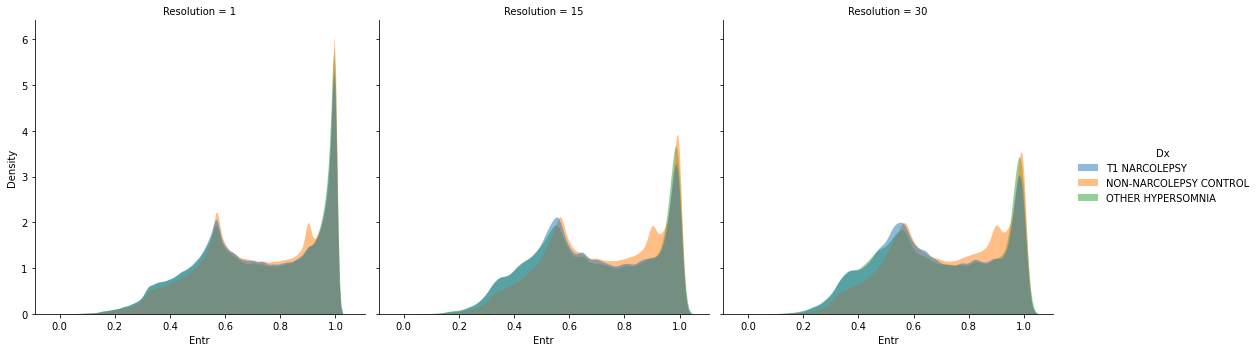

In [11]:
g = sns.displot(data=df_entr, x='Entr', hue='Dx', col='Resolution', kind='kde', common_norm=False, alpha=0.5, linewidth=0, fill=True)
g.savefig('outputs/entropy_res_dx.png', dpi=300, bbox_inches='tight')

/home/groups/mignot/miniconda3/envs/nml/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/home/groups/mignot/miniconda3/envs/nml/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/home/groups/mignot/miniconda3/envs/nml/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/home/groups/mignot/miniconda3/envs/nml/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all 

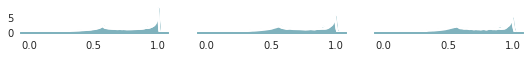

In [35]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(20, rot=-.25, light=.7)
    g = sns.FacetGrid(df_entr, hue="Dx", col="Resolution",
                      aspect=6, 
                      height=0.5, 
                      palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Entr",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "Entr", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.map(plt.axhline, y=-0.1, lw=2, clip_on=False)
    
    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)
    
    # Remove axes details that don't play well with overlap
    g.set_titles("")
#     g.set(yticks=[])
    g.despine(bottom=True, left=True)

### 10 subjects only

In [30]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(20, rot=-.25, light=.7)
    g = sns.FacetGrid(df_entr, row="ID", hue="ID", col="Resolution",
                      aspect=6, 
                      height=0.5, 
                      palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Entr",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "Entr", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.map(plt.axhline, y=-0.1, lw=2, clip_on=False)
    
    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)
    
    # Remove axes details that don't play well with overlap
    g.set_titles("")
#     g.set(yticks=[])
    g.despine(bottom=True, left=True)

KeyboardInterrupt: 

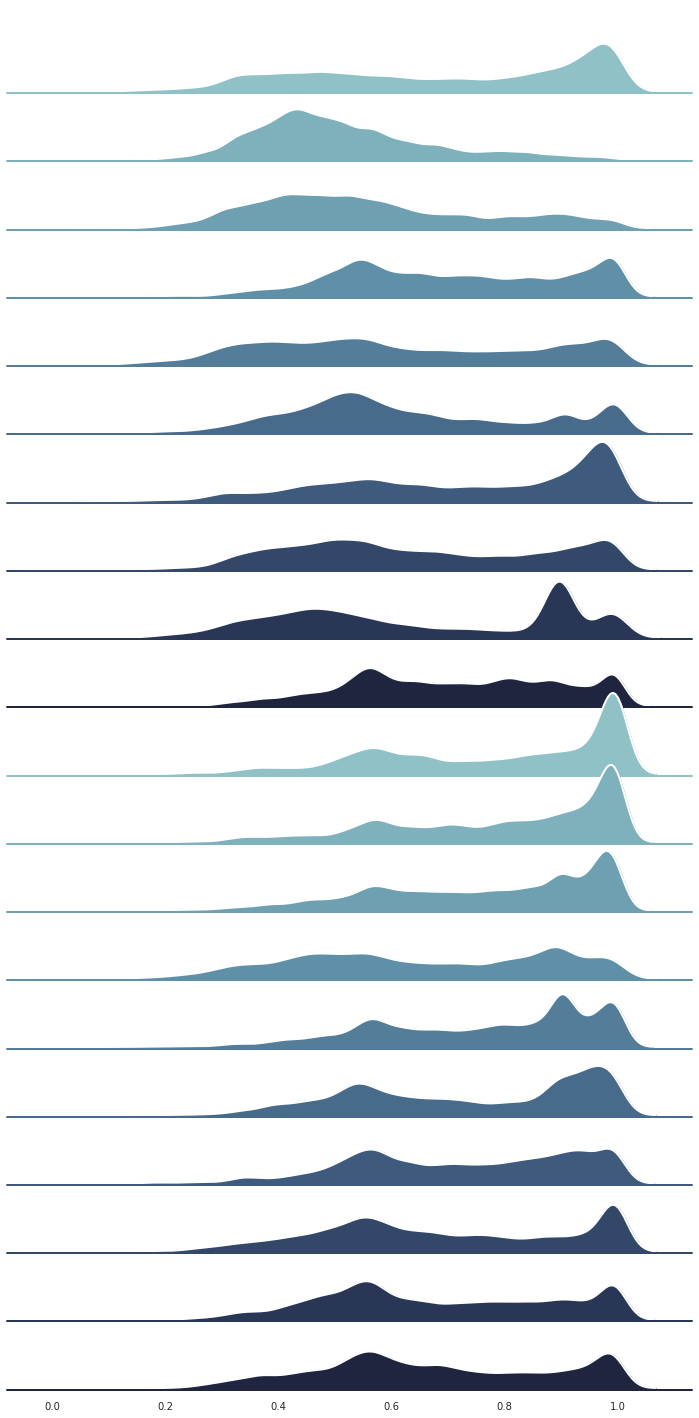

In [10]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df_entr.query('Resolution == 15'), row="ID", hue="ID", 
                      aspect=10, 
                      height=1, 
                      palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Entr",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "Entr", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.map(plt.axhline, y=-0.1, lw=2, clip_on=False)
    
    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)
    
    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)